# Robust covariance estimators

In this notebook we estimate the covariance matrix of the temperature and salinity profiles in the Argo data using the [minimum covariance determinant](https://scikit-learn.org/stable/modules/covariance.html#robust-covariance) appproach (MCD).  This estimator is robust to outliers and can be used to identify unusual observations in large collections of high-dimensional data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
from sklearn.covariance import MinCovDet
from statsmodels.nonparametric.smoothers_lowess import lowess
from read import *

Each profile is interpolated onto a grid of 100 pressure values, and we have many profiles.

In [2]:
temp.shape

(100, 50295)

In [3]:
def run_mcd(X, label):

    # Run the fast MCD algorithm to estimate the covariance matrix.
    cc = MinCovDet().fit(X)

    # Compare the estimated means
    plt.clf()
    plt.grid(True)
    plt.plot(pressure, cc.location_, label="Robust mean")
    plt.plot(pressure, cc.raw_location_, label="Sample mean")
    plt.xlabel("Pressure", size=15)
    plt.ylabel("Mean %s" % label.lower(), size=15)
    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.legend(ha, lb, loc="upper right")
    plt.show()

    # Get the MCD covariance matrix
    cv = cc.covariance_

    # Get the conventional covariance matrix
    c0 = cc.raw_covariance_

    # Compare the spectra of the two covariance matrix estimates
    a,_ = np.linalg.eigh(cv)
    b,_ = np.linalg.eigh(c0)
    plt.clf()
    plt.grid(True)
    plt.plot(np.log(a), np.log(b), "-o")
    plt.xlabel("MCD covariance", size=15)
    plt.ylabel("Conventional covariance", size=15)
    plt.title("Comparison of spectra for %s" % label.lower())
    plt.show()

    # Get the squared distance of each observation to the center of the
    # distribution using the MCD covariance.
    dmcd = cc.mahalanobis(X)

    # Get the squared distance of each observation to the center
    # of the distribution using the conventional covariance.
    Xc = X - cc.location_
    dcov = (Xc * np.linalg.solve(c0, Xc.T).T).sum(1)

    plt.clf()
    plt.grid(True)
    plt.title("Log distances to center for %s" % label.lower())
    plt.plot(np.log(dmcd), np.log(dcov), "o", alpha=0.2)
    plt.xlabel("Log MCD distance to center", size=15)
    plt.ylabel("Log conventional distance to center", size=15)
    plt.show()

    # Plot outlying points.
    for di in [dmcd, dcov]:
        ii = np.argsort(-di)

        # Plot the outlier profiles
        plt.clf()
        plt.grid(True)
        plt.title("%s outliers" % ("MCD" if di is dmcd else "Sample covariance"))
        plt.plot(pressure, cc.location_, label="Robust mean")
        for i in ii[0:15]:
            plt.plot(pressure, X[i, :], color="grey", alpha=0.8)
        ha, lb = plt.gca().get_legend_handles_labels()
        leg = plt.legend(ha, lb, loc="upper right")
        plt.xlabel("Pressure", size=15)
        plt.ylabel(label, size=15)
        plt.show()
        
        # Plot the locations of the outliers
        plt.clf()
        plt.grid(True)
        plt.plot(lon, lat, "o", color="grey", alpha=0.3, rasterized=True)
        plt.plot(lon[ii[0:15]], lat[ii[0:15]], "o", color="red")
        plt.xlabel("Longitude", size=15)
        plt.ylabel("Latitude", size=15)
        plt.show()
        
    return cc

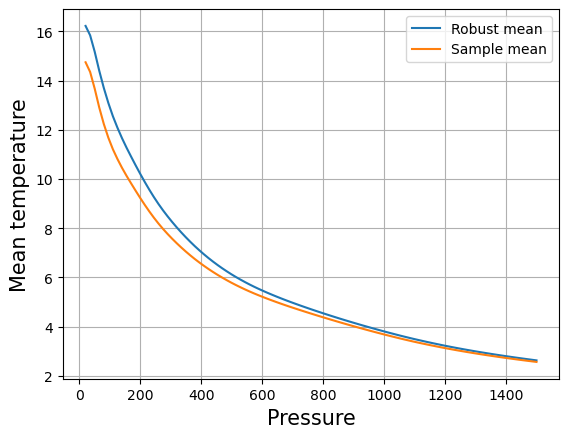

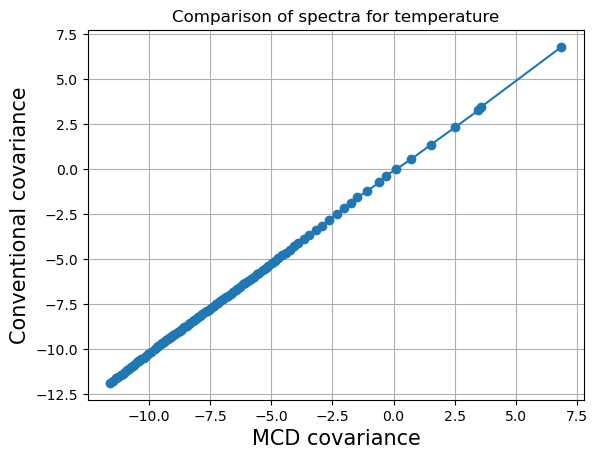

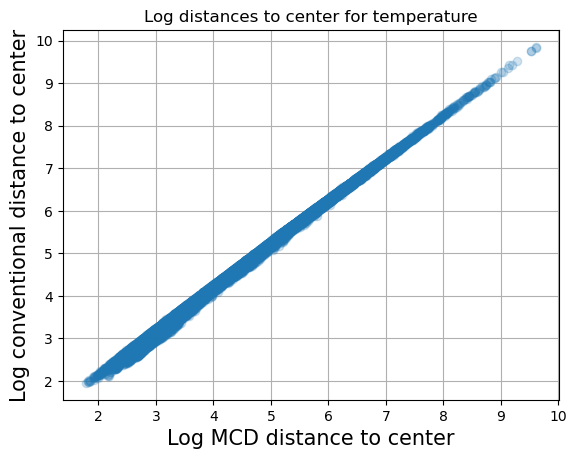

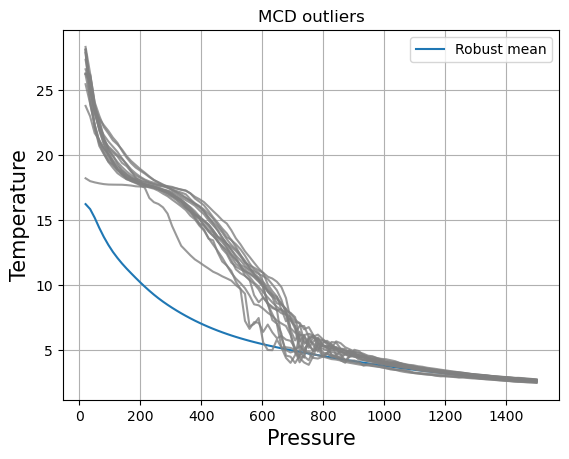

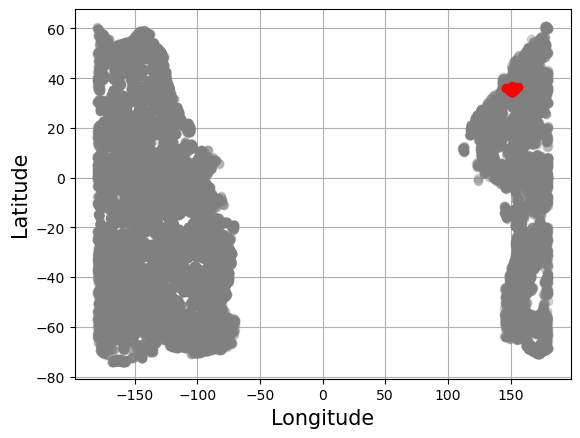

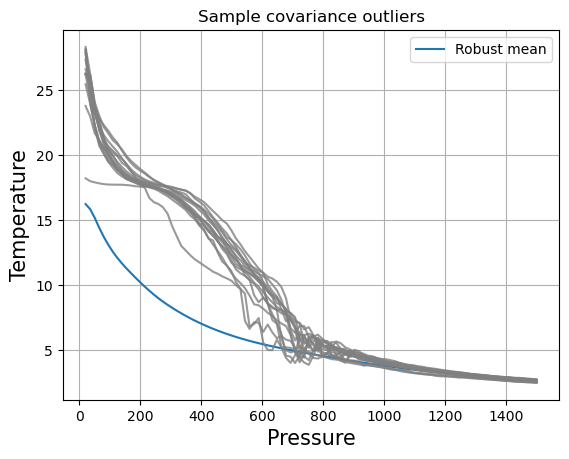

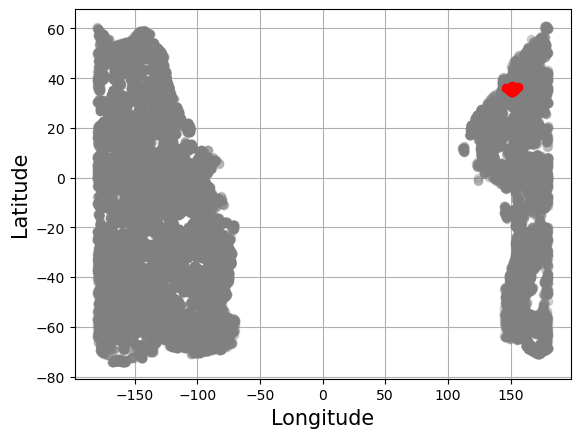

In [4]:
cc_temp = run_mcd(temp.T, "Temperature")

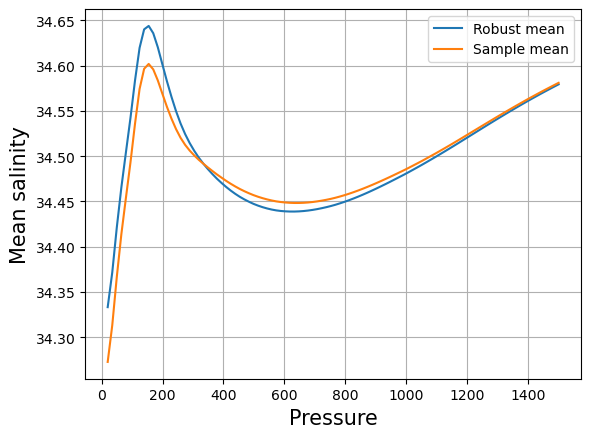

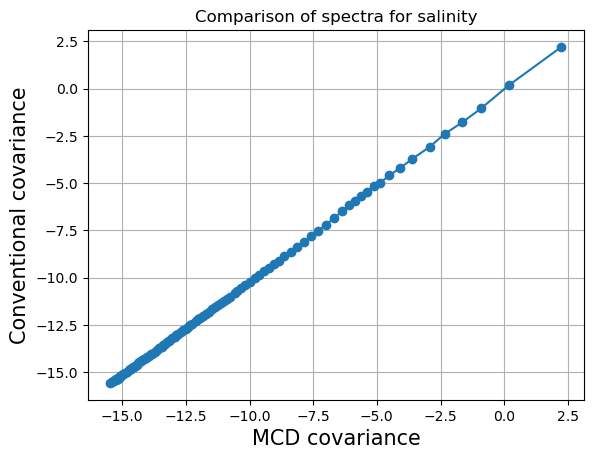

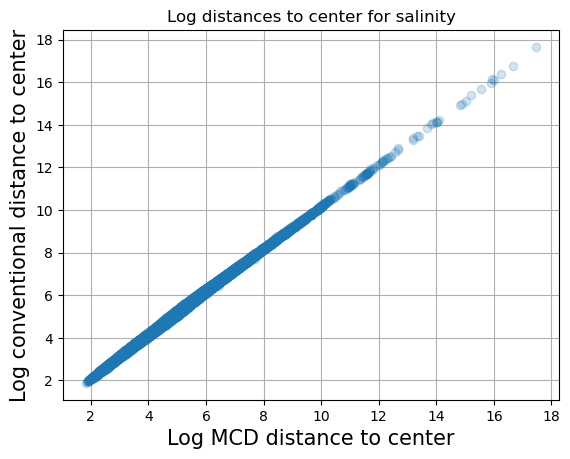

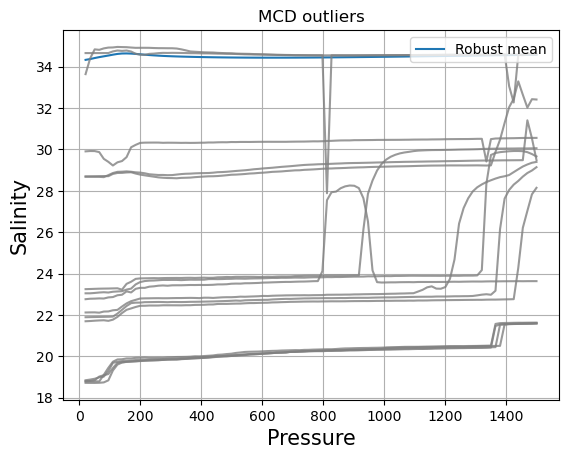

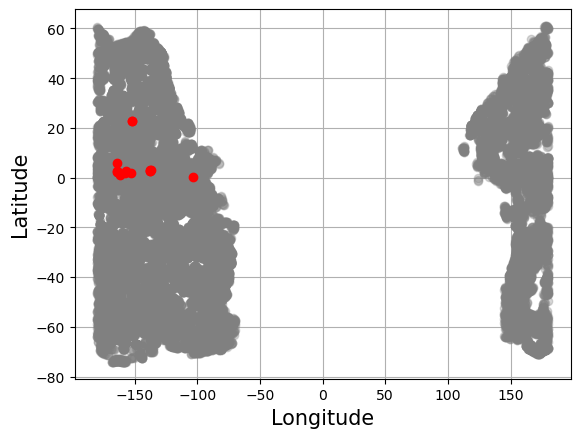

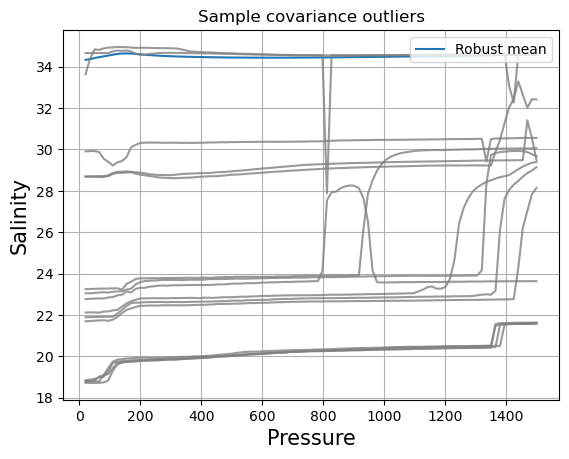

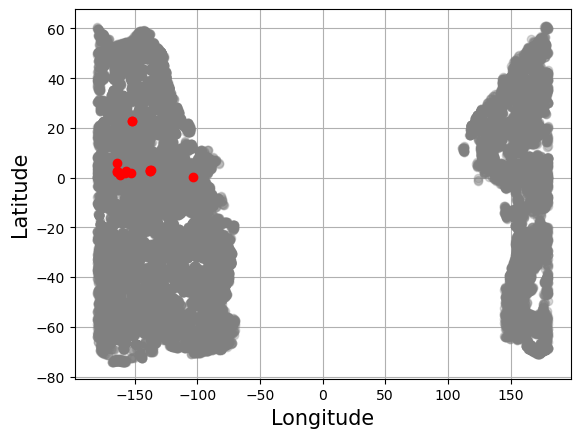

In [5]:
cc_psal = run_mcd(psal.T, "Salinity")

In [6]:
def plot_md_map(dp, title):
    plt.clf()
    plt.figure(figsize=(8, 7.25))
    ax = plt.axes([0.05, 0.05, 0.92, 0.88], projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    ax.set_extent([115, 290, -70, 60])

    qq = np.argsort(np.argsort(dp)) / len(dp)
    qq = np.floor(5*qq).astype(int)
    for i in range(5):
        ii = np.flatnonzero(qq == i)
        plt.scatter(lon[ii], lat[ii], s=8, transform=ccrs.Geodetic(), label=str(i+1))

    ha,lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right", handletextpad=0.01)
    leg.draw_frame(False)

    plt.title(title)
    plt.show()

We can use the covariance estimate to estimate Mahalanobis depths.  We then stratify the profiles based on depth and plot them by location on a map.

<Figure size 640x480 with 0 Axes>

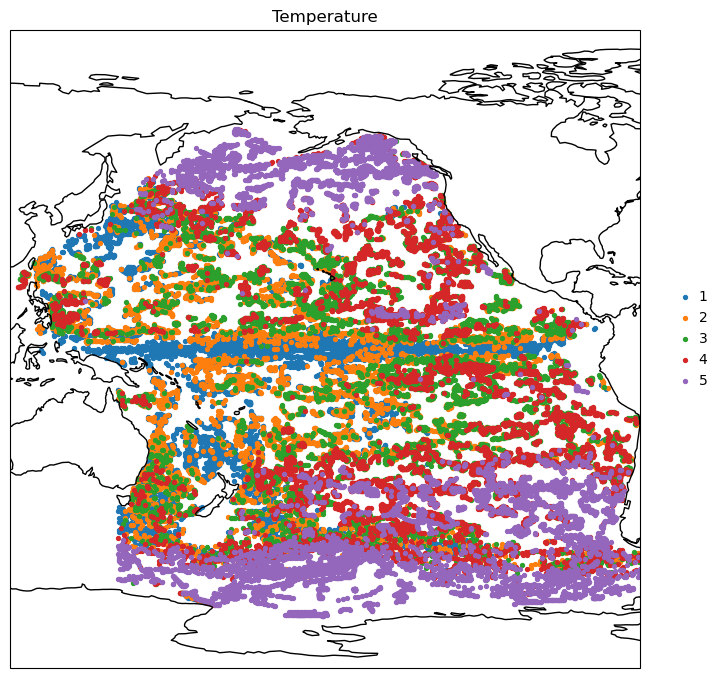

In [7]:
d_temp = 1 / (1 + cc_temp.mahalanobis(temp.T))
plot_md_map(d_temp, "Temperature")

<Figure size 640x480 with 0 Axes>

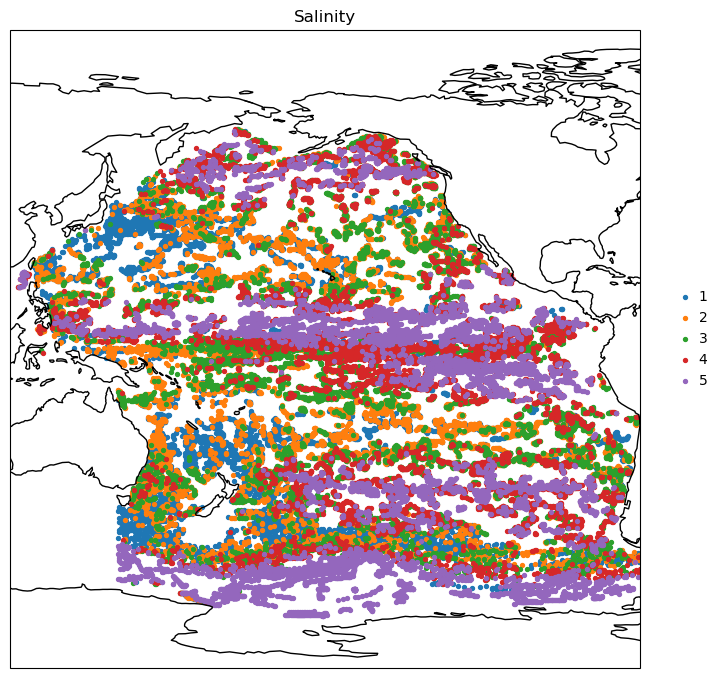

In [8]:
d_psal = 1 / (1 + cc_psal.mahalanobis(psal.T))
plot_md_map(d_psal, "Salinity")

Below we plot the locations of the extremely shallow points, and plot the extremely shallow profiles.

In [9]:
def plot_md_outlying(X, dp, title):
    plt.clf()
    plt.figure(figsize=(8, 7.25))
    ax = plt.axes([0.05, 0.05, 0.92, 0.88], projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    ax.set_extent([115, 290, -70, 60])

    tt = [0.01, 0.001]
    
    qq = np.argsort(np.argsort(dp)) / len(dp)
    for t in tt:
        ii = np.flatnonzero(qq <= t)
        plt.scatter(lon[ii], lat[ii], s=8, transform=ccrs.Geodetic(), label=str(t))

    ha,lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right", handletextpad=0.01)
    leg.draw_frame(False)

    plt.title(title)
    plt.show()
    
    for t in tt:
        plt.clf()
        plt.grid(True)
        ii = np.flatnonzero(qq <= t)
        for i in ii:
            plt.plot(pressure, X[:, i], "-", color="grey", alpha=0.2)
        plt.plot(pressure, X.mean(1), "-", color="blue")
        plt.xlabel("Pressure")
        plt.ylabel(title)
        plt.show()

<Figure size 640x480 with 0 Axes>

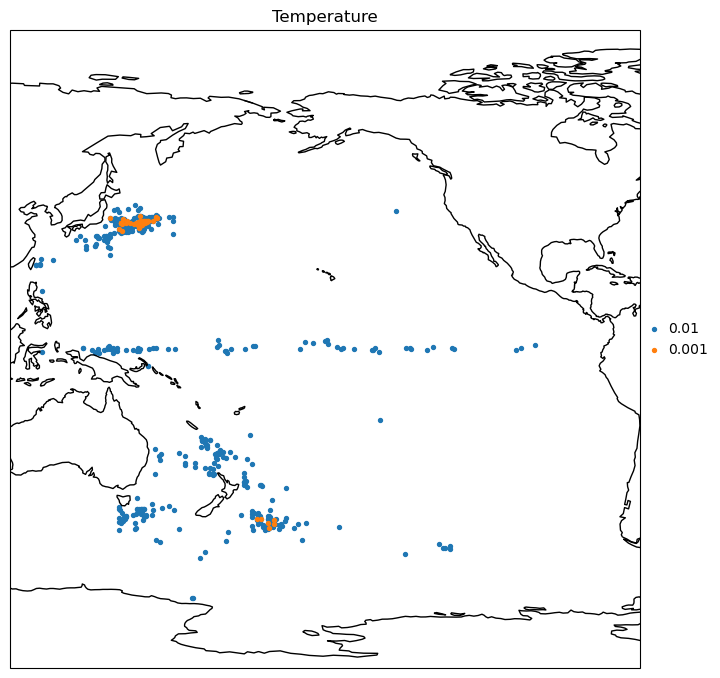

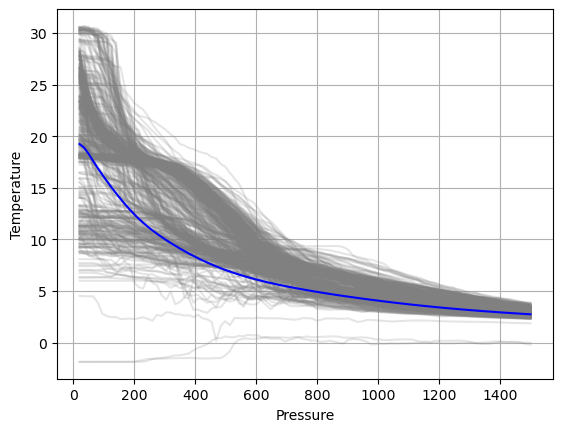

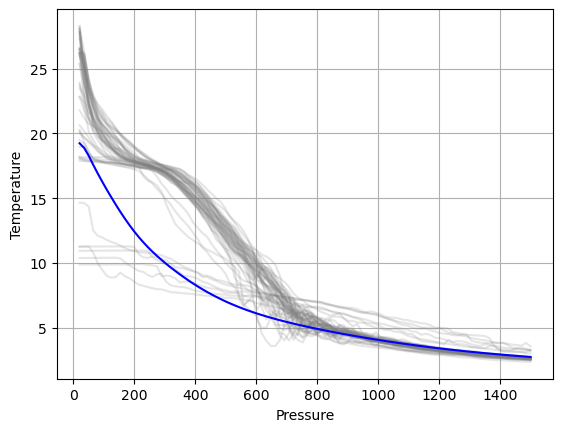

In [10]:
plot_md_outlying(temp, d_temp, "Temperature")

<Figure size 640x480 with 0 Axes>

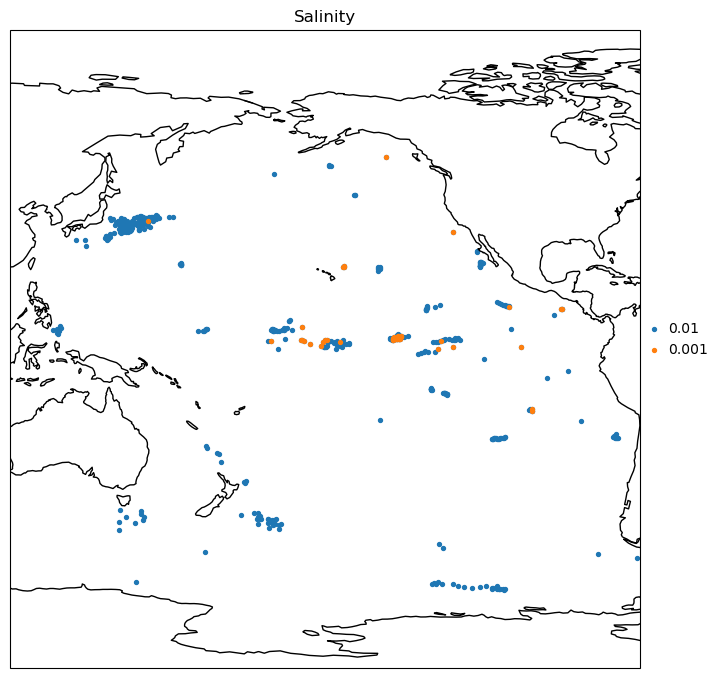

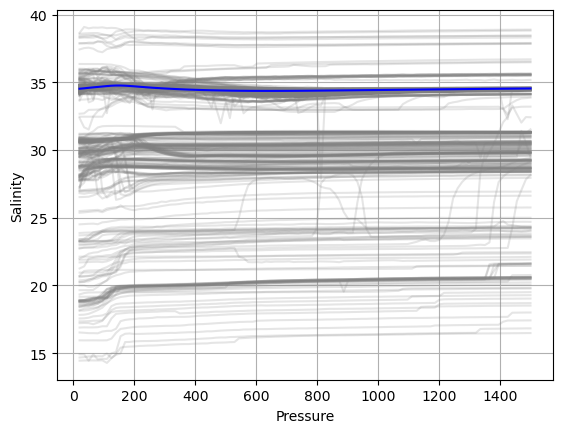

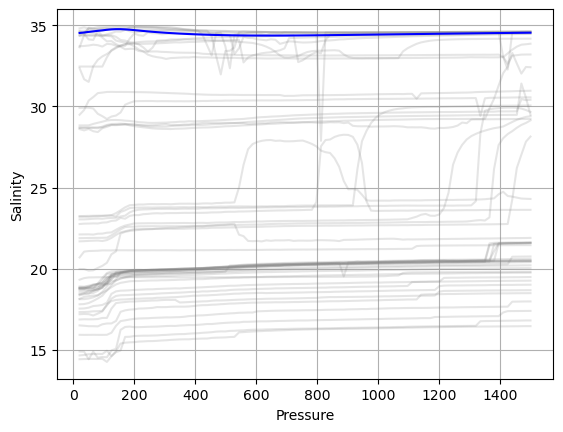

In [11]:
plot_md_outlying(psal, d_psal, "Salinity")